In [1]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.2.2+cu118
True
1


In [2]:
import torch
import torch.nn as nn
from torch import Tensor

from bitlinear import BitLinear

In [3]:
class BitLinear158b(BitLinear):
    def __init__(self, in_features, out_features, bias=True, bits=8):
        super().__init__(in_features, out_features, bias, bits)
        # 2. BitLinear b158では、[0, Qb]のスケーリングは行わないため、flg_before_linearは使用しません。
        del self.flg_before_linear
        
    # 1. quantize_weightsを{-1, 1}の2値化から{-1, 0, 1}の3値化に修正
    def quantize_weights(self):
        # 式(3): betaの計算
        beta = self.weight.abs().mean().clamp(min=self.epsilon)

        # 式(1),(2): 重みの量子化(-1, 0, 1)とクリップ
        # 各値は{-1, 0, +1}の中で最も近い整数に丸められます。
        weight_scaled = self.weight / beta
        weight_trinarized = torch.round(weight_scaled)
        weight_trinarized = torch.clamp(weight_trinarized, -1, 1)

        # STE
        weight_trinarized = (weight_trinarized - self.weight).detach() + weight_scaled

        return weight_trinarized, beta
    
    # 2. BitLinear b158では、[0, Qb]のスケーリングは行わないません。
    def absmax_quantize(self, x):
        # スケールgammaの計算（absmax quantization）
        gamma = torch.abs(x).max().clamp(min=self.epsilon)

        # 重みの量子化とクリップ
        x_scaled = x * self.Qb / gamma
        x_q = torch.round(x_scaled)
        x_q = torch.clamp(x_q, -self.Qb, self.Qb - 1)
        
        # STE
        x_q = (x_q - x_scaled).detach() + x_scaled
        
        return x_q, gamma


In [4]:
#Mnistでの動作確認
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms

# データセットの読み込み：28x28の画像データ
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# モデルの定義
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.fc = nn.Linear(32, 10)
        self.fc_bit1 = BitLinear158b(784, 512, bits=8)
        self.fc_bit2 = BitLinear158b(512, 32, bits=8)


    def forward(self, x):
        x = self.fc_bit1(x)
        x = torch.relu(x)
        x = self.fc_bit2(x)
        x = torch.relu(x)
        x = self.fc(x)
        return x
    
model = MnistModel().cuda()

# 損失関数と最適化手法の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習
hist_avg_loss = []
hist_train_acc = []
hist_valid_acc = []
model.train()

for epoch in range(20):
    avg_loss = 0
    correct = 0
    total = 0
    for x, t in train_loader:
        x, t = x.cuda(), t.cuda()
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        _, pred = y.max(1)
        correct += (pred == t).sum().item()
        total += x.size(0)
    avg_loss /= len(train_loader)
    acc = correct / total
    hist_avg_loss.append(avg_loss)
    hist_train_acc.append(acc)

    correct = 0
    total = 0
    for x, t in test_loader:
        x, t = x.cuda(), t.cuda()
        y = model(x)
        _, pred = y.max(1)
        correct += (pred == t).sum().item()
        total += x.size(0)

    acc = correct / total
    hist_valid_acc.append(acc)

    print(f"epoch: {epoch}, avg_loss: {avg_loss}, train_acc: {hist_train_acc[-1]}, valid_acc: {hist_valid_acc[-1]}")


epoch: 0, avg_loss: 0.4244066732429238, train_acc: 0.8780666666666667, valid_acc: 0.9405
epoch: 1, avg_loss: 0.1580233048163116, train_acc: 0.95355, valid_acc: 0.9637
epoch: 2, avg_loss: 0.10178406597343462, train_acc: 0.9700833333333333, valid_acc: 0.9683
epoch: 3, avg_loss: 0.07413629790954689, train_acc: 0.97755, valid_acc: 0.9742
epoch: 4, avg_loss: 0.05571261241134486, train_acc: 0.9827833333333333, valid_acc: 0.9777
epoch: 5, avg_loss: 0.04143345468381702, train_acc: 0.9873666666666666, valid_acc: 0.9777
epoch: 6, avg_loss: 0.032640864941051236, train_acc: 0.9902, valid_acc: 0.9786
epoch: 7, avg_loss: 0.0257919639505859, train_acc: 0.9922166666666666, valid_acc: 0.9807
epoch: 8, avg_loss: 0.02010481538244092, train_acc: 0.9942333333333333, valid_acc: 0.9792
epoch: 9, avg_loss: 0.01610039046177192, train_acc: 0.9954, valid_acc: 0.9817
epoch: 10, avg_loss: 0.013972588347520298, train_acc: 0.9959333333333333, valid_acc: 0.9803
epoch: 11, avg_loss: 0.011825022887118827, train_acc: 0.

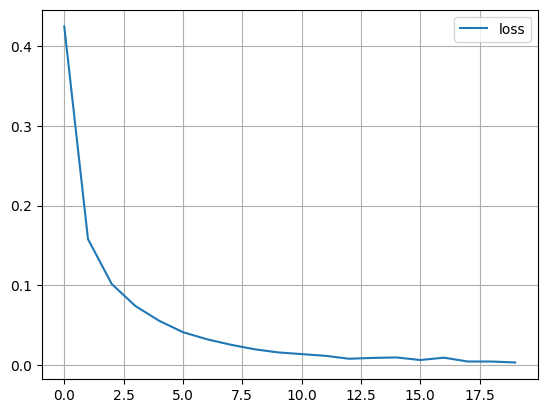

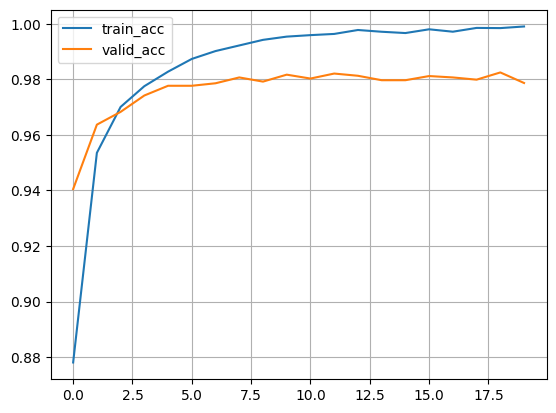

In [5]:
# 学習曲線の表示
import matplotlib.pyplot as plt

# 損失と精度の推移
plt.figure()
plt.plot(hist_avg_loss, label="loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(hist_train_acc, label="train_acc")
plt.plot(hist_valid_acc, label="valid_acc")
plt.legend()
plt.grid()

plt.show()

In [6]:
# モデルの保存
torch.save(model.state_dict(), "mnist_model_b158.pth")